In [1]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
from PIL import Image
from matplotlib import pyplot as plt
import random, os
from tqdm import tqdm

In [4]:
# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes_1 = lambda aug: iaa.Sometimes(0.3, aug)

sometimes_2 = lambda aug: iaa.Sometimes(0.3, aug)

sometimes_3 = lambda aug: iaa.Sometimes(0.15, aug)
# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.

seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5),  # horizontally flip 50% of all images
        iaa.Flipud(0.2),  # vertically flip 20% of all images

        sometimes_2(iaa.Crop(percent=(0.05, 0.5), keep_size=True)),
        # change brightness of images (by -10 to 10 of original value)
        sometimes_2(iaa.Add((-40, 40), per_channel=0.5)),
        # change hue and saturation
        sometimes_2(iaa.AddToHueAndSaturation((-20, 20))),
        # either change the brightness of the whole image (sometimes
        # per channel) or change the brightness of subareas
        sometimes_2(iaa.OneOf([
            iaa.Multiply((0.5, 1.5), per_channel=0.5),
            iaa.FrequencyNoiseAlpha(
                exponent=(-4, 0),
                first=iaa.Multiply((0.5, 1.5), per_channel=True),
                second=iaa.LinearContrast((0.5, 2.0))
            )
        ])),
        # improve or worsen the contrast
        sometimes_2(iaa.LinearContrast((0.5, 2.0), per_channel=0.5)),
        sometimes_2(iaa.PerspectiveTransform(scale=(0.1, 0.2), keep_size=True)),

        sometimes_3(iaa.Cutout(fill_mode="gaussian", fill_per_channel=True)),

        # crop images by -5% to 10% of their height/width
        sometimes_1(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode='reflect',
            pad_cval=(0, 255), keep_size=True
        )),
        sometimes_1(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-20, 20), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            # cval=0,
            mode='reflect' # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # sometimes_2(iaa.ChangeColorTemperature((3000, 10000))),

        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 2),
            [
                # sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0, 0.5)),
                    iaa.DirectedEdgeDetect(alpha=(0, 0.5), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                # iaa.Invert(0.05, per_channel=True), # invert color channels
                
                # iaa.Grayscale(alpha=(0.0, 1.0)),
                # sometimes_1(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                # sometimes_1(iaa.PiecewiseAffine(scale=(0.01, 0.1))), # sometimes move parts of the image around
            ],
            random_order=True
        )
    ],
    random_order=True
)


In [ ]:
# random example images
# images = np.random.randint(0, 255, (16, 128, 128, 3), dtype=np.uint8)
image = np.array(Image.open('/mnt/data-ssd/wa/overlay/FgBgAug/bg/raw/3-frame020.png')) # h, w = 1024, 1280
# image = image[80:1014, 10:1270, :] # hwc
# print(image.shape)
images = np.expand_dims(image, axis=0)
# print(images.shape)
plt.imshow(images[0])

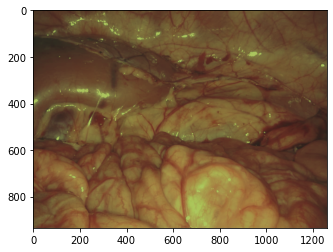

In [141]:
images_aug = seq(images=images)
plt.imshow(images_aug[0])

img = Image.fromarray(images_aug[0])
img.save('0.png')

In [7]:

N = 50
for i in tqdm(range(N), ncols=100):
    images_aug = seq(images=images)
    img = Image.fromarray(images_aug[0])
    img.save('/mnt/data-ssd/wa/overlay/FgBgAug/bg/aug_2/'+str(i)+'.png', 'PNG')

100%|███████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.27it/s]
